# **0. Setting Google Drive**

In [ ]:
#Set google drive
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### ***Do not forget to set your directory name correctly***

In [ ]:
import os
dir_name = 'AI_Chem/final'  # path to the folder you made starting from your google drive home directory.
if dir_name[0] == '/': dir_name = dir_name[1:]
if dir_name[-1] == '/': dir_name = dir_name[:-1]
os.chdir(f'/content/gdrive/MyDrive/{dir_name}/')
os.listdir(os.getcwd())  # check all the python files are in the directory.

['train_set.csv',
 '.ipynb_checkpoints',
 'test_set_public.csv',
 'v3',
 'v4',
 'dropout',
 'dropout_L2',
 'dropout_wo-reg_L2',
 'dropout0.5_wo-reg_L2',
 'dropout0.5_dimx2_wo-reg_L2',
 'test_set_private.csv',
 'template',
 'test_public_submission.csv',
 'test_private_submission.csv',
 'test_public_submission_95.csv',
 'test_private_submission_95.csv',
 'test_public_submission_79.csv',
 'test_private_submission_79.csv',
 'test_public_submission_58.csv',
 'test_private_submission_58.csv']

In [ ]:
pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 91.4 MB/s 


In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from rdkit import Chem
from rdkit.Chem.AllChem import GetAdjacencyMatrix
from rdkit.Chem.Crippen import MolLogP
from functools import reduce # optional
from tqdm import tqdm # optional
import numpy as np


In [ ]:
### GPU Setting
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#device = torch.device("cuda:0")

### CPU Setting
device = torch.device("cpu") # use this line if you are running code on CPU

# **1. Define Dataset**

In [ ]:
class GNNDataset(Dataset):

    def __init__(self, raw_data):
        super().__init__()
        smi_list = []
        pkbhx_list = []

        for row in raw_data:
          smi_list.append(row[1])
          pkbhx_list.append(float(row[2]))

        self.smi_list = smi_list
        self.pkbhx_list = pkbhx_list
        self._set_mol_list()
        self._set_atom_list()

    def __len__(self):
        return len(self.smi_list)

    def __getitem__(self, idx):
        '''
        return a dict of {"input": input, "output": output, "adj": adj, "num_atom": num_atom}
        where input is a float tensor of atom feature matrix,
        output is a float tensor of corresponding logp value,
        adj is a float tensor of adjacency matrix, and
        num_atom is a float tensor of number of atoms.
        use self._get_node_feature_matrix, self._get_adjacency_matrix, and self._get_logp.
        '''
        sample = dict()
        mol = self.mol_list[idx]

        input = self._get_node_feature_matrix(mol)
        output = np.array([self.pkbhx_list[idx]])
        adj = self._get_adjacency_matrix(mol)

        sample = {
                "input": torch.LongTensor(input),
                "output": torch.Tensor(output),
                "adj": torch.Tensor(adj),
                "num_atom": torch.Tensor([mol.GetNumAtoms()])
        }
        return sample

    def _set_mol_list(self):
        assert len(self.smi_list) > 0
        self.mol_list = [Chem.MolFromSmiles(smi) for smi in self.smi_list]

    def _set_atom_list(self, atom_list=None):
        assert len(self.mol_list) > 0
        if atom_list is not None:
            self.atom_list = atom_list
        else:
            whole_atom = list(reduce(lambda x, y: x | y, \
                    [set([a.GetSymbol() for a in mol.GetAtoms()]) \
                    for mol in self.mol_list]))
            self.atom_list = sorted(whole_atom)

    def _get_num_atom_feature(self):
        assert len(self.atom_list) > 0
        return len(self.atom_list)+4

    def _get_node_feature_matrix(self, mol):
        return np.array([self._get_atom_feature_vector(a) for a in mol.GetAtoms()])

    def _get_adjacency_matrix(self, mol):
        """
        return normalized adjacency matrix of a given molecule
        use GetAdjacencyMatrix()
        """
        def normalizeAdjacency(adj):
            """
            return a normalized adjacency matrix: D^-1/2 @ (A + I) @ D^-1/2
            """
            assert adj.shape[0] == adj.shape[1]
            A = adj + np.eye(adj.shape[0]) # Add self-loop
            d = np.sum(A, axis=1) # Degree matrix of (A + I)
            d = 1/np.sqrt(d)
            D = np.diag(d)
            return D @ A @ D
        ##########Implement Here!##########
        return normalizeAdjacency(GetAdjacencyMatrix(mol))
        ###################################

    def _get_atom_feature_vector(self, atom):
        """
        return one-hot encoded vector of a given atom
        use atom.GetSymbol() and self._get_one_hot_vector()
        """
        ##########Implement Here!##########
        sym = self._get_one_hot_vector(self.atom_list.index(atom.GetSymbol()), self._get_num_atom_feature())
        val = 1.0*np.array([atom.GetTotalValence()])
        n_hydrogen = 1.0*np.array([atom.GetTotalNumHs()])
        f_charge = 1.0*np.array([atom.GetFormalCharge()])
        if atom.GetIsAromatic():
          arom = np.array([1.0,])
        else:
          arom = np.array([0.0,])

        return np.concatenate((sym,val,n_hydrogen,f_charge,arom))
        ###################################

    def _get_one_hot_vector(self, idx, vec_dim):
        return np.eye(vec_dim)[idx]

In [ ]:
def random_splitter(dataset, train_ratio, validation_ratio, test_ratio):
    import random
    import copy
    assert train_ratio + validation_ratio + test_ratio == 1.0
    N = len(dataset)
    all_idx = list(range(N))
    random.shuffle(all_idx)

    train_idx = all_idx[:int(train_ratio * N)]
    valid_idx = all_idx[int(train_ratio * N):int(validation_ratio * N) \
                        + int(train_ratio * N)]
    test_idx = all_idx[int(validation_ratio * N) + int(train_ratio * N):]
    train_dataset = copy.deepcopy(dataset)
    valid_dataset = copy.deepcopy(dataset)
    test_dataset  = copy.deepcopy(dataset)
    train_dataset.smi_list = [dataset.smi_list[i] for i in train_idx]
    valid_dataset.smi_list = [dataset.smi_list[i] for i in valid_idx]
    test_dataset.smi_list =  [dataset.smi_list[i] for i in  test_idx]
    return train_dataset, valid_dataset, test_dataset

In [ ]:
def sample_collate_fn(samples):
    '''
    Dataloader will make a list of samples with a len(samples) = batch_size.
    Collate function should pad all the tensors in every sample at maximum size,
    and stack them on a batch dimension.

    Example)
    if four tensors of shape (3, 7), (2, 7), (6, 7), (4, 7) is given,
    collated tensor will have a shape of (4, 6, 7) where 4 is a batch size.
    '''
    def get_max_size(tensors):
        size_list = [tensor.shape for tensor in tensors]
        max_size = sorted(size_list, \
                key=lambda x: int(torch.prod(torch.tensor(x))))[-1]
        return max_size

    def max_padding(tensor, size):
        assert tensor.shape[0] <= size[0] and tensor.shape[1] <= size[1]
        max_tensor = torch.zeros(*size)
        max_tensor[:tensor.shape[0], :tensor.shape[1]] = tensor
        return max_tensor

    input_list = [sample["input"] for sample in samples]
    adj_list = [sample["adj"] for sample in samples]
    input_max_size = get_max_size(input_list)
    adj_max_size = get_max_size(adj_list)

    inputs = torch.stack([max_padding(input, input_max_size) \
            for input in input_list], dim=0)
    adjs = torch.stack([max_padding(adj, adj_max_size) \
            for adj in adj_list], dim=0)
    outputs = torch.stack([sample["output"] for sample in samples], dim=0)
    num_atoms = torch.stack([sample["num_atom"] for sample in samples], dim=0)

    sample_batch = {
            "input": inputs,
            "output": outputs,
            "adj": adjs,
            "num_atom": num_atoms
    }
    return sample_batch

# **2. Define Model**

In [ ]:
class GNNRegressor(nn.Module):

    def __init__(
            self,
            n_in,
            n_hidden1,
            n_hidden2,
            n_hidden3,
            n_gnn_layer
            ):
        super().__init__()

        self.n_in = n_in
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_hidden3 = n_hidden3
        self.n_gnn_layer = n_gnn_layer
        self.activation = nn.ReLU()

        self.embedding = nn.Linear(n_in, 512)
        self.gnns = nn.ModuleList([nn.Linear(512, 352), nn.Linear(352,n_hidden2)])
        self.dense = nn.Linear(n_hidden2, n_hidden3)
        self.fc = nn.ModuleList([nn.Linear(n_hidden3, 352),
                                 nn.Linear(352, 192),
                                    nn.Linear(192, 640),
                                    nn.Linear(640, 320),
                                    nn.Linear(320, 320),
                                    nn.Linear(320, 768)])
        self.dropout = nn.Dropout(0.5)
        self.fc_layer = nn.Linear(768, 1)

    def sum_readout(self, h):
        ##########Implement Here!##########
        return h.sum(dim=1)
        ###################################

    def forward(self, x, adj):
        '''
        x (torch.Tensor): atom feature matrix [B N F] [batch num_atom num_feature]
        adj (torch.Tensor): adjacency matrix [B N N]

        1. embed x
        2. go through self.gnns for graph convolution (A @ H @ W)
        3. go through sum readout
        4. go through the self.fc_layer to make a prediction of logp
        '''
        ##########Implement Here!##########
        x = self.embedding(x)
        for gnn in self.gnns:
          x = gnn(x)
          x = torch.matmul(adj, x)
          x = self.activation(x)
          x = self.dropout(x)
        x = x.sum(dim=1)
        x = self.dense(x)

        for fc in self.fc:
          x = fc(x)
        return self.fc_layer(x)
        ###################################

# **3. Hyperparameter Settings**

In [ ]:
########## DO NOT CHANGE ##########
NUM_EPOCH = 300
LR = 5e-5
N_HIDDEN1 = 512
N_HIDDEN2 = 352
N_HIDDEN3 = 128
N_GNN_LAYER = 3
BATCH_SIZE = 8
DATA_DIR = "./train_set.csv"
LOSS_FN = nn.MSELoss()
N_IN = 20
####################################

# **4. Build the Dataset**

In [ ]:
import csv

In [ ]:
data_list = []
with open('train_set.csv', 'r') as file:
    reader = csv.reader(file)
    header = next(reader)
    for row in reader:
        data_list.append(row)

dataset = GNNDataset(data_list)
train_dataset, valid_dataset, test_dataset = \
        random_splitter(dataset, 1.0, 0.0, 0.0)

##########Implement Here!##########
dataset._get_num_atom_feature()
###################################

16

In [ ]:
dataset.atom_list

['As', 'Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'Se', 'Si']

# **5. Build the DataLoader**

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, \
                              shuffle=True, collate_fn=sample_collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, \
                              shuffle=False, collate_fn=sample_collate_fn)
test_dataloader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, \
                              shuffle=False, collate_fn=sample_collate_fn)
tr_N = len(train_dataset)
va_N = len(valid_dataset)
te_N = len(test_dataset)

# **6. Set Model and Optimizer**

In [ ]:
model = GNNRegressor(
            N_IN,
            N_HIDDEN1,
            N_HIDDEN2,
            N_HIDDEN3,
            N_GNN_LAYER
        )
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=5e-4)

### GPU Setting
model = model.to(device)

# **7. Train with Mini-batches**

In [ ]:
def batch_to_device(batch, device):
    for k, v in batch.items():
        batch[k] = v.to(device)
    return batch

In [ ]:
save_dir = "./dropout0.5_l2big_wo-reg_L2/"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

train_loss_history, valid_loss_history = [], []
best_loss = 1e6
for i in range(1, NUM_EPOCH + 1):

    model.train()
    train_batch_losses = []
    for batch_idx, batch in tqdm(enumerate(train_dataloader), total=tr_N // BATCH_SIZE):
        batch = batch_to_device(batch, device)
        x_batch = batch["input"].float()
        y_batch = batch["output"].float()
        adj_batch = batch["adj"].float()

        y_pred = model(x_batch, adj_batch)

        loss = LOSS_FN(y_pred, y_batch)
        train_batch_losses.append(loss.data.cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_avg_loss = np.mean(np.array(train_batch_losses))
    train_loss_history.append(train_avg_loss)

    if train_avg_loss < best_loss:
        best_epoch = i
        best_loss = train_avg_loss

    print(f"\t{i}th EPOCH --- TRAIN LOSS: {train_avg_loss:.4f} BEST EPOCH: {best_epoch}", flush=True)

    torch.save(model.state_dict(), os.path.join(save_dir, f"save_{i}.pt"))

49it [00:03, 15.09it/s]                        

	1th EPOCH --- TRAIN LOSS: 1.2465 BEST EPOCH: 1



49it [00:02, 18.18it/s]                        

	2th EPOCH --- TRAIN LOSS: 0.9096 BEST EPOCH: 2



49it [00:01, 37.82it/s]

	3th EPOCH --- TRAIN LOSS: 0.8610 BEST EPOCH: 3



49it [00:01, 33.66it/s]                        

	4th EPOCH --- TRAIN LOSS: 0.8757 BEST EPOCH: 3



49it [00:01, 37.93it/s]                        

	5th EPOCH --- TRAIN LOSS: 0.7609 BEST EPOCH: 5



49it [00:01, 36.52it/s]                        

	6th EPOCH --- TRAIN LOSS: 0.7484 BEST EPOCH: 6



49it [00:01, 36.19it/s]                        

	7th EPOCH --- TRAIN LOSS: 0.7339 BEST EPOCH: 7



49it [00:01, 37.61it/s]                        

	8th EPOCH --- TRAIN LOSS: 0.6933 BEST EPOCH: 8



49it [00:01, 34.88it/s]                        

	9th EPOCH --- TRAIN LOSS: 0.6688 BEST EPOCH: 9



49it [00:01, 36.92it/s]

	10th EPOCH --- TRAIN LOSS: 0.6598 BEST EPOCH: 10



49it [00:01, 36.62it/s]                        

	11th EPOCH --- TRAIN LOSS: 0.6782 BEST EPOCH: 10



49it [00:01, 36.33it/s]                        

	12th EPOCH --- TRAIN LOSS: 0.6031 BEST EPOCH: 12



49it [00:01, 35.89it/s]                        

	13th EPOCH --- TRAIN LOSS: 0.6575 BEST EPOCH: 12



49it [00:01, 37.55it/s]                        

	14th EPOCH --- TRAIN LOSS: 0.5360 BEST EPOCH: 14



49it [00:02, 20.83it/s]

	15th EPOCH --- TRAIN LOSS: 0.6331 BEST EPOCH: 14



49it [00:02, 21.88it/s]                        

	16th EPOCH --- TRAIN LOSS: 0.5320 BEST EPOCH: 16



49it [00:01, 37.29it/s]                        

	17th EPOCH --- TRAIN LOSS: 0.5284 BEST EPOCH: 17



49it [00:01, 37.29it/s]                        

	18th EPOCH --- TRAIN LOSS: 0.5875 BEST EPOCH: 17



49it [00:01, 37.22it/s]                        

	19th EPOCH --- TRAIN LOSS: 0.5670 BEST EPOCH: 17



49it [00:01, 36.09it/s]                        

	20th EPOCH --- TRAIN LOSS: 0.5344 BEST EPOCH: 17



49it [00:01, 37.27it/s]                        

	21th EPOCH --- TRAIN LOSS: 0.5164 BEST EPOCH: 21



49it [00:02, 20.95it/s]                        

	22th EPOCH --- TRAIN LOSS: 0.5103 BEST EPOCH: 22



49it [00:02, 18.81it/s]                        

	23th EPOCH --- TRAIN LOSS: 0.6198 BEST EPOCH: 22



49it [00:01, 32.11it/s]                        

	24th EPOCH --- TRAIN LOSS: 0.5539 BEST EPOCH: 22



49it [00:01, 26.28it/s]                        


	25th EPOCH --- TRAIN LOSS: 0.5005 BEST EPOCH: 25


49it [00:02, 18.96it/s]                        

	26th EPOCH --- TRAIN LOSS: 0.5413 BEST EPOCH: 25



49it [00:01, 34.91it/s]                        

	27th EPOCH --- TRAIN LOSS: 0.5175 BEST EPOCH: 25



49it [00:01, 30.88it/s]                        

	28th EPOCH --- TRAIN LOSS: 0.5257 BEST EPOCH: 25



49it [00:01, 34.55it/s]                        

	29th EPOCH --- TRAIN LOSS: 0.4847 BEST EPOCH: 29



49it [00:02, 23.92it/s]                        

	30th EPOCH --- TRAIN LOSS: 0.4821 BEST EPOCH: 30



49it [00:01, 33.22it/s]                        

	31th EPOCH --- TRAIN LOSS: 0.5093 BEST EPOCH: 30



49it [00:02, 19.62it/s]                        

	32th EPOCH --- TRAIN LOSS: 0.4916 BEST EPOCH: 30



49it [00:01, 26.15it/s]                        

	33th EPOCH --- TRAIN LOSS: 0.5649 BEST EPOCH: 30



49it [00:02, 22.01it/s]                        

	34th EPOCH --- TRAIN LOSS: 0.4779 BEST EPOCH: 34



49it [00:02, 19.79it/s]                        

	35th EPOCH --- TRAIN LOSS: 0.5124 BEST EPOCH: 34



49it [00:02, 23.46it/s]                        

	36th EPOCH --- TRAIN LOSS: 0.5620 BEST EPOCH: 34



49it [00:02, 23.05it/s]                        

	37th EPOCH --- TRAIN LOSS: 0.5290 BEST EPOCH: 34



49it [00:02, 22.38it/s]                        

	38th EPOCH --- TRAIN LOSS: 0.5058 BEST EPOCH: 34



49it [00:02, 21.77it/s]                        

	39th EPOCH --- TRAIN LOSS: 0.4386 BEST EPOCH: 39



49it [00:02, 19.35it/s]                        

	40th EPOCH --- TRAIN LOSS: 0.4722 BEST EPOCH: 39



49it [00:02, 21.27it/s]                        

	41th EPOCH --- TRAIN LOSS: 0.4830 BEST EPOCH: 39



49it [00:02, 21.34it/s]                        

	42th EPOCH --- TRAIN LOSS: 0.4501 BEST EPOCH: 39



49it [00:02, 20.79it/s]                        

	43th EPOCH --- TRAIN LOSS: 0.4705 BEST EPOCH: 39



49it [00:02, 20.80it/s]                        

	44th EPOCH --- TRAIN LOSS: 0.4648 BEST EPOCH: 39



49it [00:02, 20.10it/s]                        

	45th EPOCH --- TRAIN LOSS: 0.4824 BEST EPOCH: 39



49it [00:02, 20.32it/s]                        

	46th EPOCH --- TRAIN LOSS: 0.4590 BEST EPOCH: 39



49it [00:02, 20.95it/s]                        

	47th EPOCH --- TRAIN LOSS: 0.5025 BEST EPOCH: 39



49it [00:02, 19.78it/s]

	48th EPOCH --- TRAIN LOSS: 0.4717 BEST EPOCH: 39



49it [00:02, 19.71it/s]                        

	49th EPOCH --- TRAIN LOSS: 0.4672 BEST EPOCH: 39



49it [00:04, 11.94it/s]

	50th EPOCH --- TRAIN LOSS: 0.4585 BEST EPOCH: 39



49it [00:03, 15.18it/s]                        

	51th EPOCH --- TRAIN LOSS: 0.4463 BEST EPOCH: 39



49it [00:02, 20.02it/s]                        

	52th EPOCH --- TRAIN LOSS: 0.4370 BEST EPOCH: 52



49it [00:02, 18.23it/s]                        

	53th EPOCH --- TRAIN LOSS: 0.4314 BEST EPOCH: 53



49it [00:02, 19.38it/s]                        

	54th EPOCH --- TRAIN LOSS: 0.4514 BEST EPOCH: 53



49it [00:02, 18.94it/s]                        

	55th EPOCH --- TRAIN LOSS: 0.4565 BEST EPOCH: 53



49it [00:02, 18.77it/s]                        

	56th EPOCH --- TRAIN LOSS: 0.4243 BEST EPOCH: 56



49it [00:02, 18.60it/s]                        

	57th EPOCH --- TRAIN LOSS: 0.4386 BEST EPOCH: 56



49it [00:02, 18.62it/s]                        

	58th EPOCH --- TRAIN LOSS: 0.4476 BEST EPOCH: 56



49it [00:02, 17.98it/s]                        

	59th EPOCH --- TRAIN LOSS: 0.4113 BEST EPOCH: 59



49it [00:02, 17.82it/s]                        

	60th EPOCH --- TRAIN LOSS: 0.4292 BEST EPOCH: 59



49it [00:02, 17.62it/s]                        

	61th EPOCH --- TRAIN LOSS: 0.4305 BEST EPOCH: 59



49it [00:02, 17.53it/s]                        

	62th EPOCH --- TRAIN LOSS: 0.4183 BEST EPOCH: 59



49it [00:02, 17.24it/s]                        

	63th EPOCH --- TRAIN LOSS: 0.4261 BEST EPOCH: 59



49it [00:02, 17.02it/s]                        

	64th EPOCH --- TRAIN LOSS: 0.4040 BEST EPOCH: 64



49it [00:02, 16.81it/s]                        

	65th EPOCH --- TRAIN LOSS: 0.3922 BEST EPOCH: 65



49it [00:02, 16.87it/s]                        

	66th EPOCH --- TRAIN LOSS: 0.4038 BEST EPOCH: 65



49it [00:02, 16.91it/s]                        

	67th EPOCH --- TRAIN LOSS: 0.4518 BEST EPOCH: 65



49it [00:02, 17.11it/s]                        

	68th EPOCH --- TRAIN LOSS: 0.4115 BEST EPOCH: 65



49it [00:02, 16.46it/s]                        

	69th EPOCH --- TRAIN LOSS: 0.3972 BEST EPOCH: 65



49it [00:02, 16.55it/s]                        

	70th EPOCH --- TRAIN LOSS: 0.4942 BEST EPOCH: 65



49it [00:02, 16.37it/s]                        

	71th EPOCH --- TRAIN LOSS: 0.4079 BEST EPOCH: 65



49it [00:03, 15.96it/s]                        

	72th EPOCH --- TRAIN LOSS: 0.4149 BEST EPOCH: 65



49it [00:03, 15.82it/s]                        

	73th EPOCH --- TRAIN LOSS: 0.4003 BEST EPOCH: 65



49it [00:03, 15.65it/s]                        

	74th EPOCH --- TRAIN LOSS: 0.4276 BEST EPOCH: 65



49it [00:03, 15.51it/s]                        

	75th EPOCH --- TRAIN LOSS: 0.3833 BEST EPOCH: 75



49it [00:03, 15.62it/s]                        

	76th EPOCH --- TRAIN LOSS: 0.3936 BEST EPOCH: 75



49it [00:03, 15.44it/s]                        

	77th EPOCH --- TRAIN LOSS: 0.4072 BEST EPOCH: 75



49it [00:03, 14.91it/s]                        

	78th EPOCH --- TRAIN LOSS: 0.4037 BEST EPOCH: 75



49it [00:04, 12.04it/s]                        

	79th EPOCH --- TRAIN LOSS: 0.4050 BEST EPOCH: 75



49it [00:03, 14.27it/s]                        

	80th EPOCH --- TRAIN LOSS: 0.4691 BEST EPOCH: 75



49it [00:03, 14.61it/s]                        

	81th EPOCH --- TRAIN LOSS: 0.4102 BEST EPOCH: 75



49it [00:03, 14.42it/s]                        

	82th EPOCH --- TRAIN LOSS: 0.4119 BEST EPOCH: 75



49it [00:03, 14.11it/s]                        

	83th EPOCH --- TRAIN LOSS: 0.3983 BEST EPOCH: 75



49it [00:03, 13.09it/s]                        

	84th EPOCH --- TRAIN LOSS: 0.3787 BEST EPOCH: 84



49it [00:03, 13.94it/s]                        

	85th EPOCH --- TRAIN LOSS: 0.3993 BEST EPOCH: 84



49it [00:03, 14.02it/s]                        

	86th EPOCH --- TRAIN LOSS: 0.4148 BEST EPOCH: 84



49it [00:03, 13.00it/s]                        

	87th EPOCH --- TRAIN LOSS: 0.4267 BEST EPOCH: 84



49it [00:03, 13.72it/s]                        

	88th EPOCH --- TRAIN LOSS: 0.3926 BEST EPOCH: 84



49it [00:03, 13.40it/s]                        

	89th EPOCH --- TRAIN LOSS: 0.4092 BEST EPOCH: 84



49it [00:03, 12.80it/s]                        

	90th EPOCH --- TRAIN LOSS: 0.3907 BEST EPOCH: 84



49it [00:03, 13.08it/s]                        

	91th EPOCH --- TRAIN LOSS: 0.3934 BEST EPOCH: 84



49it [00:03, 12.67it/s]                        

	92th EPOCH --- TRAIN LOSS: 0.3735 BEST EPOCH: 92



49it [00:03, 12.95it/s]                        

	93th EPOCH --- TRAIN LOSS: 0.3936 BEST EPOCH: 92



49it [00:03, 12.54it/s]                        

	94th EPOCH --- TRAIN LOSS: 0.3797 BEST EPOCH: 92



49it [00:03, 12.29it/s]                        

	95th EPOCH --- TRAIN LOSS: 0.4157 BEST EPOCH: 92



49it [00:04, 12.14it/s]                        

	96th EPOCH --- TRAIN LOSS: 0.4052 BEST EPOCH: 92



49it [00:04, 11.69it/s]                        

	97th EPOCH --- TRAIN LOSS: 0.3878 BEST EPOCH: 92



49it [00:04, 11.68it/s]                        

	98th EPOCH --- TRAIN LOSS: 0.4134 BEST EPOCH: 92



49it [00:04, 11.53it/s]                        

	99th EPOCH --- TRAIN LOSS: 0.3713 BEST EPOCH: 99



49it [00:04, 11.34it/s]                        

	100th EPOCH --- TRAIN LOSS: 0.3688 BEST EPOCH: 100



49it [00:04, 11.14it/s]                        

	101th EPOCH --- TRAIN LOSS: 0.3801 BEST EPOCH: 100



49it [00:04, 10.95it/s]                        

	102th EPOCH --- TRAIN LOSS: 0.3978 BEST EPOCH: 100



49it [00:04, 10.72it/s]                        

	103th EPOCH --- TRAIN LOSS: 0.3921 BEST EPOCH: 100



49it [00:04, 10.84it/s]                        

	104th EPOCH --- TRAIN LOSS: 0.3646 BEST EPOCH: 104



49it [00:04, 10.80it/s]                        

	105th EPOCH --- TRAIN LOSS: 0.3884 BEST EPOCH: 104



49it [00:04, 10.80it/s]                        

	106th EPOCH --- TRAIN LOSS: 0.3817 BEST EPOCH: 104



49it [00:04, 10.79it/s]                        

	107th EPOCH --- TRAIN LOSS: 0.3631 BEST EPOCH: 107



49it [00:04, 10.78it/s]                        

	108th EPOCH --- TRAIN LOSS: 0.3958 BEST EPOCH: 107



49it [00:04, 10.74it/s]                        

	109th EPOCH --- TRAIN LOSS: 0.3843 BEST EPOCH: 107



49it [00:04, 10.16it/s]

	110th EPOCH --- TRAIN LOSS: 0.3838 BEST EPOCH: 107



49it [00:04, 10.56it/s]                        

	111th EPOCH --- TRAIN LOSS: 0.3631 BEST EPOCH: 111



49it [00:04, 10.30it/s]                        

	112th EPOCH --- TRAIN LOSS: 0.3883 BEST EPOCH: 111



49it [00:04, 10.22it/s]

	113th EPOCH --- TRAIN LOSS: 0.4372 BEST EPOCH: 111



49it [00:04,  9.90it/s]

	114th EPOCH --- TRAIN LOSS: 0.4046 BEST EPOCH: 111



49it [00:05,  9.66it/s]

	115th EPOCH --- TRAIN LOSS: 0.3791 BEST EPOCH: 111



49it [00:05,  9.52it/s]                        

	116th EPOCH --- TRAIN LOSS: 0.3643 BEST EPOCH: 111



49it [00:05,  9.24it/s]                        

	117th EPOCH --- TRAIN LOSS: 0.3623 BEST EPOCH: 117



49it [00:05,  9.49it/s]                        

	118th EPOCH --- TRAIN LOSS: 0.3679 BEST EPOCH: 117



49it [00:04, 11.77it/s]                        

	119th EPOCH --- TRAIN LOSS: 0.3651 BEST EPOCH: 117



49it [00:03, 15.37it/s]                        

	120th EPOCH --- TRAIN LOSS: 0.3585 BEST EPOCH: 120



49it [00:03, 16.04it/s]                        

	121th EPOCH --- TRAIN LOSS: 0.3591 BEST EPOCH: 120



49it [00:02, 16.37it/s]                        

	122th EPOCH --- TRAIN LOSS: 0.3632 BEST EPOCH: 120



49it [00:03, 15.90it/s]                        

	123th EPOCH --- TRAIN LOSS: 0.4242 BEST EPOCH: 120



49it [00:03, 12.72it/s]                        

	124th EPOCH --- TRAIN LOSS: 0.3627 BEST EPOCH: 120



49it [00:03, 16.01it/s]                        

	125th EPOCH --- TRAIN LOSS: 0.3691 BEST EPOCH: 120



49it [00:03, 15.66it/s]                        

	126th EPOCH --- TRAIN LOSS: 0.3760 BEST EPOCH: 120



49it [00:03, 14.60it/s]                        

	127th EPOCH --- TRAIN LOSS: 0.3687 BEST EPOCH: 120



49it [00:03, 13.29it/s]                        

	128th EPOCH --- TRAIN LOSS: 0.3639 BEST EPOCH: 120



49it [00:03, 14.08it/s]                        

	129th EPOCH --- TRAIN LOSS: 0.3772 BEST EPOCH: 120



49it [00:03, 14.76it/s]                        

	130th EPOCH --- TRAIN LOSS: 0.3521 BEST EPOCH: 130



49it [00:03, 15.12it/s]                        

	131th EPOCH --- TRAIN LOSS: 0.3618 BEST EPOCH: 130



49it [00:03, 15.06it/s]                        

	132th EPOCH --- TRAIN LOSS: 0.3490 BEST EPOCH: 132



49it [00:03, 15.11it/s]                        

	133th EPOCH --- TRAIN LOSS: 0.3607 BEST EPOCH: 132



49it [00:03, 14.90it/s]                        

	134th EPOCH --- TRAIN LOSS: 0.3750 BEST EPOCH: 132



49it [00:03, 14.73it/s]                        

	135th EPOCH --- TRAIN LOSS: 0.3508 BEST EPOCH: 132



49it [00:03, 14.29it/s]                        

	136th EPOCH --- TRAIN LOSS: 0.3547 BEST EPOCH: 132



49it [00:03, 14.38it/s]                        

	137th EPOCH --- TRAIN LOSS: 0.3781 BEST EPOCH: 132



49it [00:03, 15.38it/s]                        

	138th EPOCH --- TRAIN LOSS: 0.3493 BEST EPOCH: 132



49it [00:03, 15.18it/s]                        

	139th EPOCH --- TRAIN LOSS: 0.3835 BEST EPOCH: 132



49it [00:03, 15.07it/s]                        

	140th EPOCH --- TRAIN LOSS: 0.3450 BEST EPOCH: 140



49it [00:03, 15.55it/s]                        

	141th EPOCH --- TRAIN LOSS: 0.3762 BEST EPOCH: 140



49it [00:03, 15.37it/s]                        

	142th EPOCH --- TRAIN LOSS: 0.4147 BEST EPOCH: 140



49it [00:03, 15.49it/s]                        

	143th EPOCH --- TRAIN LOSS: 0.3649 BEST EPOCH: 140



49it [00:03, 14.97it/s]                        

	144th EPOCH --- TRAIN LOSS: 0.3386 BEST EPOCH: 144



49it [00:03, 14.92it/s]                        

	145th EPOCH --- TRAIN LOSS: 0.3554 BEST EPOCH: 144



49it [00:03, 15.11it/s]                        

	146th EPOCH --- TRAIN LOSS: 0.3796 BEST EPOCH: 144



49it [00:03, 15.55it/s]                        

	147th EPOCH --- TRAIN LOSS: 0.3663 BEST EPOCH: 144



49it [00:03, 15.78it/s]                        

	148th EPOCH --- TRAIN LOSS: 0.4021 BEST EPOCH: 144



49it [00:03, 15.61it/s]                        

	149th EPOCH --- TRAIN LOSS: 0.3660 BEST EPOCH: 144



49it [00:03, 15.36it/s]                        

	150th EPOCH --- TRAIN LOSS: 0.3782 BEST EPOCH: 144



49it [00:03, 15.11it/s]                        

	151th EPOCH --- TRAIN LOSS: 0.4045 BEST EPOCH: 144



49it [00:03, 14.94it/s]                        

	152th EPOCH --- TRAIN LOSS: 0.3233 BEST EPOCH: 152



49it [00:03, 14.78it/s]                        

	153th EPOCH --- TRAIN LOSS: 0.3356 BEST EPOCH: 152



49it [00:03, 14.93it/s]                        

	154th EPOCH --- TRAIN LOSS: 0.3457 BEST EPOCH: 152



49it [00:03, 14.63it/s]                        

	155th EPOCH --- TRAIN LOSS: 0.3354 BEST EPOCH: 152



49it [00:03, 14.39it/s]                        

	156th EPOCH --- TRAIN LOSS: 0.3915 BEST EPOCH: 152



49it [00:03, 14.07it/s]                        

	157th EPOCH --- TRAIN LOSS: 0.3348 BEST EPOCH: 152



49it [00:03, 14.24it/s]                        

	158th EPOCH --- TRAIN LOSS: 0.3425 BEST EPOCH: 152



49it [00:03, 13.93it/s]                        

	159th EPOCH --- TRAIN LOSS: 0.3601 BEST EPOCH: 152



49it [00:03, 13.45it/s]                        

	160th EPOCH --- TRAIN LOSS: 0.3405 BEST EPOCH: 152



49it [00:03, 13.32it/s]                        

	161th EPOCH --- TRAIN LOSS: 0.3601 BEST EPOCH: 152



49it [00:03, 13.35it/s]                        

	162th EPOCH --- TRAIN LOSS: 0.3317 BEST EPOCH: 152



49it [00:03, 13.70it/s]                        

	163th EPOCH --- TRAIN LOSS: 0.3513 BEST EPOCH: 152



49it [00:03, 13.93it/s]                        

	164th EPOCH --- TRAIN LOSS: 0.3800 BEST EPOCH: 152



49it [00:03, 13.96it/s]                        

	165th EPOCH --- TRAIN LOSS: 0.3418 BEST EPOCH: 152



49it [00:03, 12.55it/s]

	166th EPOCH --- TRAIN LOSS: 0.3794 BEST EPOCH: 152



49it [00:03, 12.39it/s]                        

	167th EPOCH --- TRAIN LOSS: 0.3686 BEST EPOCH: 152



49it [00:03, 12.97it/s]                        

	168th EPOCH --- TRAIN LOSS: 0.3225 BEST EPOCH: 168



49it [00:03, 13.05it/s]                        

	169th EPOCH --- TRAIN LOSS: 0.3362 BEST EPOCH: 168



49it [00:03, 13.39it/s]                        

	170th EPOCH --- TRAIN LOSS: 0.3498 BEST EPOCH: 168



49it [00:03, 13.90it/s]                        

	171th EPOCH --- TRAIN LOSS: 0.3628 BEST EPOCH: 168



49it [00:03, 13.57it/s]                        

	172th EPOCH --- TRAIN LOSS: 0.3317 BEST EPOCH: 168



49it [00:03, 13.54it/s]                        

	173th EPOCH --- TRAIN LOSS: 0.3454 BEST EPOCH: 168



49it [00:03, 13.41it/s]                        

	174th EPOCH --- TRAIN LOSS: 0.3233 BEST EPOCH: 168



49it [00:03, 13.07it/s]                        

	175th EPOCH --- TRAIN LOSS: 0.3129 BEST EPOCH: 175



49it [00:03, 12.77it/s]                        

	176th EPOCH --- TRAIN LOSS: 0.3636 BEST EPOCH: 175



49it [00:04, 11.40it/s]                        

	177th EPOCH --- TRAIN LOSS: 0.3720 BEST EPOCH: 175



49it [00:04, 11.04it/s]

	178th EPOCH --- TRAIN LOSS: 0.3500 BEST EPOCH: 175



49it [00:03, 12.54it/s]                        

	179th EPOCH --- TRAIN LOSS: 0.3525 BEST EPOCH: 175



49it [00:04, 12.24it/s]                        

	180th EPOCH --- TRAIN LOSS: 0.3449 BEST EPOCH: 175



49it [00:04, 12.09it/s]                        

	181th EPOCH --- TRAIN LOSS: 0.3419 BEST EPOCH: 175



49it [00:04, 11.94it/s]                        

	182th EPOCH --- TRAIN LOSS: 0.3124 BEST EPOCH: 182



49it [00:04, 11.80it/s]                        

	183th EPOCH --- TRAIN LOSS: 0.3243 BEST EPOCH: 182



49it [00:04, 11.99it/s]                        

	184th EPOCH --- TRAIN LOSS: 0.3182 BEST EPOCH: 182



49it [00:04, 12.01it/s]                        

	185th EPOCH --- TRAIN LOSS: 0.3291 BEST EPOCH: 182



49it [00:04, 12.24it/s]

	186th EPOCH --- TRAIN LOSS: 0.3308 BEST EPOCH: 182



49it [00:04, 12.12it/s]

	187th EPOCH --- TRAIN LOSS: 0.3548 BEST EPOCH: 182



49it [00:04, 11.86it/s]                        

	188th EPOCH --- TRAIN LOSS: 0.3670 BEST EPOCH: 182



49it [00:04, 11.58it/s]                        

	189th EPOCH --- TRAIN LOSS: 0.3236 BEST EPOCH: 182



49it [00:04, 11.54it/s]

	190th EPOCH --- TRAIN LOSS: 0.3212 BEST EPOCH: 182



49it [00:04, 11.47it/s]                        

	191th EPOCH --- TRAIN LOSS: 0.3631 BEST EPOCH: 182



49it [00:04, 11.41it/s]                        

	192th EPOCH --- TRAIN LOSS: 0.3248 BEST EPOCH: 182



49it [00:04, 11.06it/s]

	193th EPOCH --- TRAIN LOSS: 0.3521 BEST EPOCH: 182



49it [00:04, 11.21it/s]                        

	194th EPOCH --- TRAIN LOSS: 0.3049 BEST EPOCH: 194



49it [00:04, 11.11it/s]

	195th EPOCH --- TRAIN LOSS: 0.3363 BEST EPOCH: 194



49it [00:04, 11.11it/s]                        

	196th EPOCH --- TRAIN LOSS: 0.3123 BEST EPOCH: 194



49it [00:04, 11.66it/s]                        

	197th EPOCH --- TRAIN LOSS: 0.3267 BEST EPOCH: 194



49it [00:04, 11.77it/s]                        

	198th EPOCH --- TRAIN LOSS: 0.3485 BEST EPOCH: 194



49it [00:04, 11.71it/s]

	199th EPOCH --- TRAIN LOSS: 0.3027 BEST EPOCH: 199



49it [00:04, 11.66it/s]                        

	200th EPOCH --- TRAIN LOSS: 0.3192 BEST EPOCH: 199



49it [00:04, 11.35it/s]                        

	201th EPOCH --- TRAIN LOSS: 0.3336 BEST EPOCH: 199



49it [00:04, 11.20it/s]                        

	202th EPOCH --- TRAIN LOSS: 0.3112 BEST EPOCH: 199



49it [00:04, 11.23it/s]                        

	203th EPOCH --- TRAIN LOSS: 0.3107 BEST EPOCH: 199



49it [00:04, 11.01it/s]                        

	204th EPOCH --- TRAIN LOSS: 0.3302 BEST EPOCH: 199



49it [00:04, 10.91it/s]                        

	205th EPOCH --- TRAIN LOSS: 0.2892 BEST EPOCH: 205



49it [00:04, 10.92it/s]                        

	206th EPOCH --- TRAIN LOSS: 0.2943 BEST EPOCH: 205



49it [00:04, 11.10it/s]

	207th EPOCH --- TRAIN LOSS: 0.3071 BEST EPOCH: 205



49it [00:04, 10.94it/s]                        

	208th EPOCH --- TRAIN LOSS: 0.3181 BEST EPOCH: 205



49it [00:04, 10.95it/s]                        

	209th EPOCH --- TRAIN LOSS: 0.3136 BEST EPOCH: 205



49it [00:04, 10.70it/s]

	210th EPOCH --- TRAIN LOSS: 0.3143 BEST EPOCH: 205



49it [00:04, 10.76it/s]                        

	211th EPOCH --- TRAIN LOSS: 0.3465 BEST EPOCH: 205



49it [00:04, 10.45it/s]

	212th EPOCH --- TRAIN LOSS: 0.3006 BEST EPOCH: 205



49it [00:04, 10.29it/s]

	213th EPOCH --- TRAIN LOSS: 0.3326 BEST EPOCH: 205



49it [00:04, 10.39it/s]

	214th EPOCH --- TRAIN LOSS: 0.3143 BEST EPOCH: 205



49it [00:04, 10.45it/s]

	215th EPOCH --- TRAIN LOSS: 0.2808 BEST EPOCH: 215



49it [00:04, 10.99it/s]                        

	216th EPOCH --- TRAIN LOSS: 0.3054 BEST EPOCH: 215



49it [00:04, 11.18it/s]                        

	217th EPOCH --- TRAIN LOSS: 0.3139 BEST EPOCH: 215



49it [00:04, 10.93it/s]                        

	218th EPOCH --- TRAIN LOSS: 0.2768 BEST EPOCH: 218



49it [00:04, 10.50it/s]                        

	219th EPOCH --- TRAIN LOSS: 0.2857 BEST EPOCH: 218



49it [00:04,  9.83it/s]                        

	220th EPOCH --- TRAIN LOSS: 0.2944 BEST EPOCH: 218



49it [00:05,  9.48it/s]

	221th EPOCH --- TRAIN LOSS: 0.2837 BEST EPOCH: 218



49it [00:04, 10.68it/s]                        

	222th EPOCH --- TRAIN LOSS: 0.3147 BEST EPOCH: 218



49it [00:04, 10.52it/s]

	223th EPOCH --- TRAIN LOSS: 0.2885 BEST EPOCH: 218



49it [00:04, 10.55it/s]                        

	224th EPOCH --- TRAIN LOSS: 0.2876 BEST EPOCH: 218



49it [00:04, 10.58it/s]                        

	225th EPOCH --- TRAIN LOSS: 0.3005 BEST EPOCH: 218



49it [00:04, 10.64it/s]                        

	226th EPOCH --- TRAIN LOSS: 0.2643 BEST EPOCH: 226



49it [00:04, 10.87it/s]

	227th EPOCH --- TRAIN LOSS: 0.2949 BEST EPOCH: 226



49it [00:04, 10.82it/s]

	228th EPOCH --- TRAIN LOSS: 0.3033 BEST EPOCH: 226



49it [00:04, 10.67it/s]

	229th EPOCH --- TRAIN LOSS: 0.3038 BEST EPOCH: 226



49it [00:04, 10.73it/s]                        

	230th EPOCH --- TRAIN LOSS: 0.3110 BEST EPOCH: 226



49it [00:04, 10.39it/s]

	231th EPOCH --- TRAIN LOSS: 0.3401 BEST EPOCH: 226



49it [00:04, 10.41it/s]                        

	232th EPOCH --- TRAIN LOSS: 0.2908 BEST EPOCH: 226



49it [00:04, 10.28it/s]

	233th EPOCH --- TRAIN LOSS: 0.2933 BEST EPOCH: 226



49it [00:04, 10.35it/s]                        

	234th EPOCH --- TRAIN LOSS: 0.2703 BEST EPOCH: 226



49it [00:04, 10.59it/s]                        

	235th EPOCH --- TRAIN LOSS: 0.3040 BEST EPOCH: 226



49it [00:04, 10.58it/s]                        

	236th EPOCH --- TRAIN LOSS: 0.3227 BEST EPOCH: 226



49it [00:04, 11.13it/s]                        

	237th EPOCH --- TRAIN LOSS: 0.2940 BEST EPOCH: 226



49it [00:04, 11.35it/s]                        

	238th EPOCH --- TRAIN LOSS: 0.2817 BEST EPOCH: 226



49it [00:05,  8.24it/s]                        

	239th EPOCH --- TRAIN LOSS: 0.2822 BEST EPOCH: 226



49it [00:05,  8.64it/s]                        

	240th EPOCH --- TRAIN LOSS: 0.2733 BEST EPOCH: 226



49it [00:04, 12.14it/s]                        

	241th EPOCH --- TRAIN LOSS: 0.2582 BEST EPOCH: 241



49it [00:04, 10.73it/s]                        

	242th EPOCH --- TRAIN LOSS: 0.2999 BEST EPOCH: 241



49it [00:04, 11.57it/s]                        

	243th EPOCH --- TRAIN LOSS: 0.2705 BEST EPOCH: 241



49it [00:04, 10.09it/s]                        

	244th EPOCH --- TRAIN LOSS: 0.2950 BEST EPOCH: 241



49it [00:04, 10.76it/s]

	245th EPOCH --- TRAIN LOSS: 0.2654 BEST EPOCH: 241



49it [00:04, 11.00it/s]

	246th EPOCH --- TRAIN LOSS: 0.2912 BEST EPOCH: 241



49it [00:05,  9.34it/s]                        

	247th EPOCH --- TRAIN LOSS: 0.2711 BEST EPOCH: 241



49it [00:04, 11.58it/s]

	248th EPOCH --- TRAIN LOSS: 0.2671 BEST EPOCH: 241



49it [00:04, 11.65it/s]                        

	249th EPOCH --- TRAIN LOSS: 0.2871 BEST EPOCH: 241



49it [00:04, 11.58it/s]                        

	250th EPOCH --- TRAIN LOSS: 0.2600 BEST EPOCH: 241



49it [00:04, 11.30it/s]                        

	251th EPOCH --- TRAIN LOSS: 0.2880 BEST EPOCH: 241



49it [00:04, 11.10it/s]                        

	252th EPOCH --- TRAIN LOSS: 0.2686 BEST EPOCH: 241



49it [00:04, 11.18it/s]                        

	253th EPOCH --- TRAIN LOSS: 0.3066 BEST EPOCH: 241



49it [00:04, 11.06it/s]

	254th EPOCH --- TRAIN LOSS: 0.2835 BEST EPOCH: 241



49it [00:04, 11.01it/s]                        

	255th EPOCH --- TRAIN LOSS: 0.2569 BEST EPOCH: 255



49it [00:04, 10.99it/s]                        

	256th EPOCH --- TRAIN LOSS: 0.2986 BEST EPOCH: 255



49it [00:04, 10.81it/s]

	257th EPOCH --- TRAIN LOSS: 0.2630 BEST EPOCH: 255



49it [00:04, 10.74it/s]

	258th EPOCH --- TRAIN LOSS: 0.2809 BEST EPOCH: 255



49it [00:04, 10.68it/s]

	259th EPOCH --- TRAIN LOSS: 0.2566 BEST EPOCH: 259



49it [00:04, 10.65it/s]                        

	260th EPOCH --- TRAIN LOSS: 0.2807 BEST EPOCH: 259



49it [00:05,  8.91it/s]                        

	261th EPOCH --- TRAIN LOSS: 0.2660 BEST EPOCH: 259



49it [00:04, 10.43it/s]                        

	262th EPOCH --- TRAIN LOSS: 0.3225 BEST EPOCH: 259



49it [00:04,  9.95it/s]

	263th EPOCH --- TRAIN LOSS: 0.2608 BEST EPOCH: 259



49it [00:04, 10.54it/s]                        

	264th EPOCH --- TRAIN LOSS: 0.2744 BEST EPOCH: 259



49it [00:04, 10.42it/s]                        

	265th EPOCH --- TRAIN LOSS: 0.2644 BEST EPOCH: 259



49it [00:05,  9.41it/s]

	266th EPOCH --- TRAIN LOSS: 0.2659 BEST EPOCH: 259



49it [00:04, 10.33it/s]

	267th EPOCH --- TRAIN LOSS: 0.2636 BEST EPOCH: 259



49it [00:04, 10.18it/s]

	268th EPOCH --- TRAIN LOSS: 0.2655 BEST EPOCH: 259



49it [00:04, 10.17it/s]                        

	269th EPOCH --- TRAIN LOSS: 0.2746 BEST EPOCH: 259



49it [00:05,  9.77it/s]

	270th EPOCH --- TRAIN LOSS: 0.2704 BEST EPOCH: 259



49it [00:04,  9.88it/s]

	271th EPOCH --- TRAIN LOSS: 0.2683 BEST EPOCH: 259



49it [00:05,  9.36it/s]                        

	272th EPOCH --- TRAIN LOSS: 0.2892 BEST EPOCH: 259



49it [00:06,  7.84it/s]                        

	273th EPOCH --- TRAIN LOSS: 0.2683 BEST EPOCH: 259



49it [00:05,  9.51it/s]                        

	274th EPOCH --- TRAIN LOSS: 0.2546 BEST EPOCH: 274



49it [00:05,  9.78it/s]

	275th EPOCH --- TRAIN LOSS: 0.2360 BEST EPOCH: 275



49it [00:05,  9.72it/s]

	276th EPOCH --- TRAIN LOSS: 0.2459 BEST EPOCH: 275



49it [00:04, 10.21it/s]

	277th EPOCH --- TRAIN LOSS: 0.2763 BEST EPOCH: 275



49it [00:05,  9.79it/s]                        

	278th EPOCH --- TRAIN LOSS: 0.2457 BEST EPOCH: 275



49it [00:05,  8.20it/s]                        

	279th EPOCH --- TRAIN LOSS: 0.2615 BEST EPOCH: 275



49it [00:06,  7.12it/s]                        

	280th EPOCH --- TRAIN LOSS: 0.2658 BEST EPOCH: 275



49it [00:05,  8.56it/s]                        

	281th EPOCH --- TRAIN LOSS: 0.2248 BEST EPOCH: 281



49it [00:05,  8.41it/s]

	282th EPOCH --- TRAIN LOSS: 0.2538 BEST EPOCH: 281



49it [00:05,  9.45it/s]

	283th EPOCH --- TRAIN LOSS: 0.2603 BEST EPOCH: 281



49it [00:05,  9.49it/s]

	284th EPOCH --- TRAIN LOSS: 0.2874 BEST EPOCH: 281



49it [00:05,  9.20it/s]

	285th EPOCH --- TRAIN LOSS: 0.2555 BEST EPOCH: 281



49it [00:05,  9.15it/s]                        

	286th EPOCH --- TRAIN LOSS: 0.2628 BEST EPOCH: 281



49it [00:05,  9.02it/s]

	287th EPOCH --- TRAIN LOSS: 0.2512 BEST EPOCH: 281



49it [00:05,  9.05it/s]                        

	288th EPOCH --- TRAIN LOSS: 0.2583 BEST EPOCH: 281



49it [00:05,  8.89it/s]                        

	289th EPOCH --- TRAIN LOSS: 0.2434 BEST EPOCH: 281



49it [00:05,  9.06it/s]                        

	290th EPOCH --- TRAIN LOSS: 0.2489 BEST EPOCH: 281



49it [00:05,  8.96it/s]                        

	291th EPOCH --- TRAIN LOSS: 0.2623 BEST EPOCH: 281



49it [00:05,  9.24it/s]                        

	292th EPOCH --- TRAIN LOSS: 0.2474 BEST EPOCH: 281



49it [00:05,  9.17it/s]

	293th EPOCH --- TRAIN LOSS: 0.2479 BEST EPOCH: 281



49it [00:05,  9.46it/s]                        

	294th EPOCH --- TRAIN LOSS: 0.2591 BEST EPOCH: 281



49it [00:05,  9.46it/s]                        

	295th EPOCH --- TRAIN LOSS: 0.2549 BEST EPOCH: 281



49it [00:05,  8.89it/s]                        

	296th EPOCH --- TRAIN LOSS: 0.2445 BEST EPOCH: 281



49it [00:05,  8.55it/s]                        

	297th EPOCH --- TRAIN LOSS: 0.2933 BEST EPOCH: 281



49it [00:05,  9.50it/s]                        

	298th EPOCH --- TRAIN LOSS: 0.2426 BEST EPOCH: 281



49it [00:05,  9.43it/s]                        

	299th EPOCH --- TRAIN LOSS: 0.2562 BEST EPOCH: 281



49it [00:05,  9.23it/s]                        

	300th EPOCH --- TRAIN LOSS: 0.2329 BEST EPOCH: 281


# **8. Plot the Loss Histories**

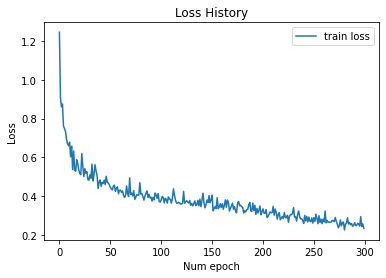

In [ ]:
import matplotlib.pyplot as plt
x_axis = np.arange(NUM_EPOCH)
fig, ax = plt.subplots()
ax.plot(x_axis, train_loss_history, label='train loss')
#ax.plot(x_axis, valid_loss_history, label='validation loss')
ax.set_xlabel('Num epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss History')
ax.legend()
fig.show()

In [ ]:
sub_list = []
with open('test_set_public.csv', 'r') as file:
    reader = csv.reader(file)
    header = next(reader)
    for row in reader:
        sub_list.append(row)

In [ ]:
class testdataset(Dataset):

    def __init__(self, raw_data):
        super().__init__()
        smi_list = []

        for row in raw_data:
          smi_list.append(row[1])

        self.smi_list = smi_list
        self._set_mol_list()
        self._set_atom_list()

    def __len__(self):
        return len(self.smi_list)

    def __getitem__(self, idx):
        '''
        return a dict of {"input": input, "output": output, "adj": adj, "num_atom": num_atom}
        where input is a float tensor of atom feature matrix,
        output is a float tensor of corresponding logp value,
        adj is a float tensor of adjacency matrix, and
        num_atom is a float tensor of number of atoms.
        use self._get_node_feature_matrix, self._get_adjacency_matrix, and self._get_logp.
        '''
        sample = dict()
        mol = self.mol_list[idx]

        input = self._get_node_feature_matrix(mol)
        adj = self._get_adjacency_matrix(mol)

        sample = {
                "input": torch.LongTensor(input),
                "adj": torch.Tensor(adj),
                "num_atom": torch.Tensor([mol.GetNumAtoms()]),
                "output": torch.Tensor(0)
        }
        return sample

    def _set_mol_list(self):
        assert len(self.smi_list) > 0
        self.mol_list = [Chem.MolFromSmiles(smi) for smi in self.smi_list]

    def _set_atom_list(self, atom_list=None):
        assert len(self.mol_list) > 0
        if atom_list is not None:
            self.atom_list = atom_list
        else:
            whole_atom = list(reduce(lambda x, y: x | y, \
                    [set([a.GetSymbol() for a in mol.GetAtoms()]) \
                    for mol in self.mol_list]))
            self.atom_list = sorted(whole_atom)

    def _get_num_atom_feature(self):
        assert len(self.atom_list) > 0
        return len(self.atom_list)+4

    def _get_node_feature_matrix(self, mol):
        return np.array([self._get_atom_feature_vector(a) for a in mol.GetAtoms()])

    def _get_adjacency_matrix(self, mol):
        """
        return normalized adjacency matrix of a given molecule
        use GetAdjacencyMatrix()
        """
        def normalizeAdjacency(adj):
            """
            return a normalized adjacency matrix: D^-1/2 @ (A + I) @ D^-1/2
            """
            assert adj.shape[0] == adj.shape[1]
            A = adj + np.eye(adj.shape[0]) # Add self-loop
            d = np.sum(A, axis=1) # Degree matrix of (A + I)
            d = 1/np.sqrt(d)
            D = np.diag(d)
            return D @ A @ D
        ##########Implement Here!##########
        return normalizeAdjacency(GetAdjacencyMatrix(mol))
        ###################################

    def _get_atom_feature_vector(self, atom):
        """
        return one-hot encoded vector of a given atom
        use atom.GetSymbol() and self._get_one_hot_vector()
        """
        ##########Implement Here!##########
        sym = self._get_one_hot_vector(self.atom_list.index(atom.GetSymbol()), self._get_num_atom_feature())
        val = 1.0*np.array([atom.GetTotalValence()])
        n_hydrogen = 1.0*np.array([atom.GetTotalNumHs()])
        f_charge = 1.0*np.array([atom.GetFormalCharge()])
        if atom.GetIsAromatic():
          arom = np.array([1.0,])
        else:
          arom = np.array([0.0,])

        return np.concatenate((sym,val,n_hydrogen,f_charge,arom))
        ###################################

    def _get_one_hot_vector(self, idx, vec_dim):
        return np.eye(vec_dim)[idx]

In [ ]:
sub_dataset = testdataset(sub_list)
sub_dataloader  = DataLoader(sub_dataset,  batch_size=BATCH_SIZE, \
                              shuffle=False, collate_fn=sample_collate_fn)
sub_N = len(sub_dataset)
ans_list = []

In [ ]:
for i in range(1,301):
  save_state_dict = torch.load(os.path.join(save_dir, f"save_{i}.pt"),map_location=torch.device('cpu'))
  model.load_state_dict(save_state_dict)
  model.eval()
  ans_list = []
  with torch.no_grad():
      test_batch_losses = []
      for batch_idx, batch in tqdm(enumerate(sub_dataloader), total=sub_N // BATCH_SIZE):
          batch = batch_to_device(batch, device)
          x_batch = batch["input"].float()
          y_batch = batch["output"].float()
          adj_batch = batch["adj"].float()

          y_pred = model(x_batch, adj_batch)

          ans_list.append(y_pred)
  with open(f'public_sub_dropout0.5_L2bigwo-reg_L2_{i}.csv', 'w') as file:
    file.write("index,pkbhx\n")
    j = 386
    for listt in ans_list:
      for num in listt:
        file.write(f"{j},{str(float(num))}\n")
        j = j+1
        if j == 420:
          break

5it [00:00, 87.09it/s]               
5it [00:00, 109.33it/s]              
5it [00:00, 110.31it/s]              
5it [00:00, 108.68it/s]              
5it [00:00, 107.84it/s]              
5it [00:00, 108.58it/s]              
5it [00:00, 86.23it/s]               
5it [00:00, 95.11it/s]               
5it [00:00, 97.59it/s]               
5it [00:00, 55.99it/s]               
5it [00:00, 74.66it/s]               
5it [00:00, 106.68it/s]              
5it [00:00, 103.65it/s]              
5it [00:00, 105.29it/s]              
5it [00:00, 106.34it/s]              
5it [00:00, 97.32it/s]               
5it [00:00, 104.30it/s]              
5it [00:00, 96.62it/s]               
5it [00:00, 105.37it/s]              
5it [00:00, 106.16it/s]              
5it [00:00, 91.17it/s]               
5it [00:00, 110.03it/s]              
5it [00:00, 109.18it/s]              
5it [00:00, 104.25it/s]              
5it [00:00, 112.94it/s]              
5it [00:00, 108.44it/s]              
5it [00:00, 

In [ ]:
save_dir = "./dropout_wo-reg_L2/"
save_state_dict = torch.load(os.path.join(save_dir, f"save_300.pt"),map_location=torch.device('cpu'))
model.load_state_dict(save_state_dict)

<All keys matched successfully>